In [1]:
import yfinance as yf
import pandas_ta as ta
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler


In [3]:
import datetime
from typing import Callable

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pandas_datareader.data as web

# Window length for moving average
length = 14

# Dates
start, end = '2010-01-01', '2013-01-27'

# Get data
data = pd.read_csv("/Users/soumenkhan/Desktop/NSE_parent/ONGC.NS_data.csv")
# Get just the adjusted close
close = data['close']

print(close.head())



0    143.094284
1    145.236252
2    146.879059
3    138.560898
4    140.598816
Name: close, dtype: float64


In [4]:
# Define function to calculate the RSI
def calc_rsi(over: pd.Series, fn_roll: Callable) -> pd.Series:
    # Get the difference in price from previous step
    delta = over.diff()
    # Get rid of the first row, which is NaN since it did not have a previous row to calculate the differences
    delta = delta[1:] 

    # Make the positive gains (up) and negative gains (down) Series
    up, down = delta.clip(lower=0), delta.clip(upper=0).abs()

    roll_up, roll_down = fn_roll(up), fn_roll(down)
    rs = roll_up / roll_down
    rsi = 100.0 - (100.0 / (1.0 + rs))

    # Avoid division-by-zero if `roll_down` is zero
    # This prevents inf and/or nan values.
    rsi[:] = np.select([roll_down == 0, roll_up == 0, True], [100, 0, rsi])
    # rsi = rsi.case_when([((roll_down == 0), 100), ((roll_up == 0), 0)])  # This alternative to np.select works only for pd.__version__ >= 2.2.0.
    rsi.name = 'rsi'

    # Assert range
    valid_rsi = rsi[length - 1:]
    assert ((0 <= valid_rsi) & (valid_rsi <= 100)).all()
    # Note: rsi[:length - 1] is excluded from above assertion because it is NaN for SMA.

    return rsi


In [9]:
# Calculate RSI using MA of choice
# Reminder: Provide ≥ `1 + length` extra data points!
rsi_ema = calc_rsi(close, lambda s: s.ewm(span=length).mean())
rsi_sma = calc_rsi(close, lambda s: s.rolling(length).mean())
rsi_rma = calc_rsi(close, lambda s: s.ewm(alpha=1 / length).mean())  # Approximates TradingView.

#print(rsi_sma.tail())

data['rsi_sma']=rsi_sma

print(data)

            date        open        high         low       close    volume  \
0     2015-01-01  141.513817  143.385418  141.451436  143.094284   1849323   
1     2015-01-02  143.115098  146.608757  143.115098  145.236252   3736468   
2     2015-01-05  144.321201  148.896231  143.905296  146.879059   6074619   
3     2015-01-06  144.965931  145.132293  137.500316  138.560898   9024997   
4     2015-01-07  138.498463  142.054502  136.460500  140.598816   8937670   
...          ...         ...         ...         ...         ...       ...   
2376  2024-08-21  328.101438  328.944893  323.983431  325.174194  11835143   
2377  2024-08-22  326.017615  327.952598  321.105787  321.850006  13387819   
2378  2024-08-23  324.399994  324.799988  317.549988  318.899994  13229612   
2379  2024-08-26  323.500000  329.100006  322.799988  327.850006  21346682   
2380  2024-08-27  329.399994  332.549988  326.000000  328.850006  20165503   

        rsi_sma  
0           NaN  
1           NaN  
2        

In [ ]:
# Compare graphically
plt.figure(figsize=(8, 6))
rsi_ema.plot(), rsi_sma.plot(), rsi_rma.plot()
plt.legend(['RSI via EMA/EWMA', 'RSI via SMA', 'RSI via RMA/SMMA/MMA (TradingView)'])
plt.show()

                  Date        Open        High         Low       Close  \
Timestamp                                                                
2015-01-01  2015-01-01  141.513832  143.385433  141.451451  143.094299   
2015-01-02  2015-01-02  143.115083  146.608742  143.115083  145.236237   
2015-01-05  2015-01-05  144.321231  148.896262  143.905326  146.879089   
2015-01-06  2015-01-06  144.965899  145.132261  137.500286  138.560867   
2015-01-07  2015-01-07  138.498493  142.054533  136.460529  140.598846   

             Volume  
Timestamp            
2015-01-01  1849323  
2015-01-02  3736468  
2015-01-05  6074619  
2015-01-06  9024997  
2015-01-07  8937670  


/Users/soumenkhan/Desktop/NSE/trading_env/lib/python3.8/site-packages/mplfinance/_arg_validators.py:84: UserWarning: 


            POSSIBLE TO SEE DETAILS (Candles, Ohlc-Bars, Etc.)
   For more information see:
   - https://github.com/matplotlib/mplfinance/wiki/Plotting-Too-Much-Data
   
   TO SILENCE THIS WARNING, set `type='line'` in `mpf.plot()`
   OR set kwarg `warn_too_much_data=N` where N is an integer 
   LARGER than the number of data points you want to plot.

  warnings.warn('\n\n ================================================================= '+


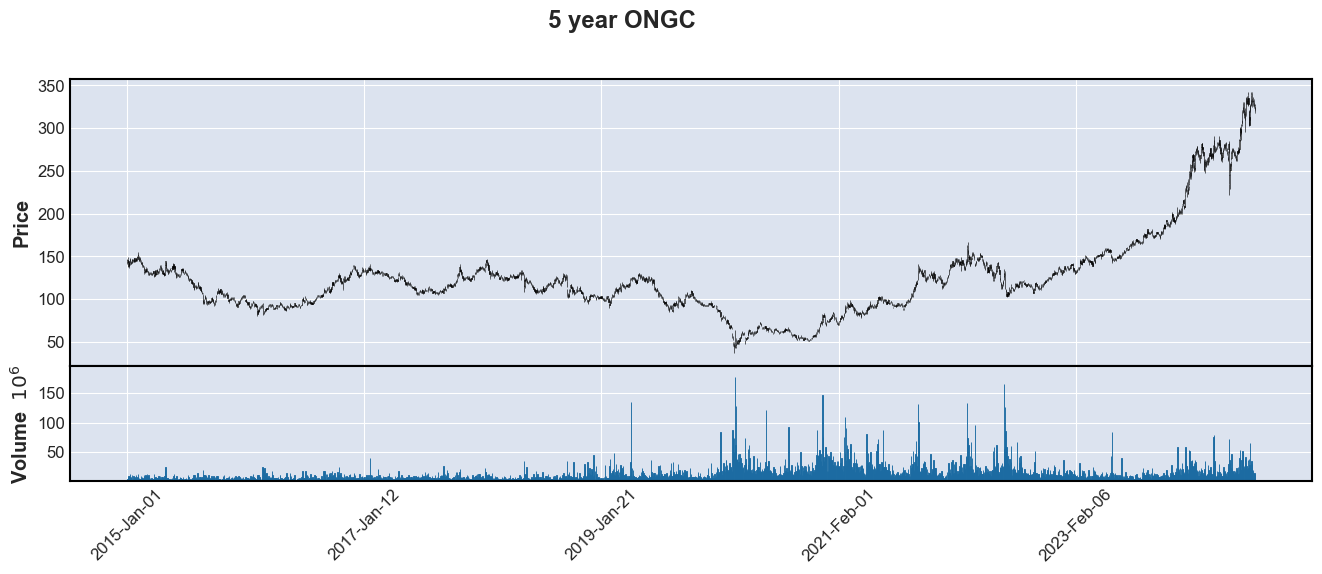

"\nfig = go.Figure(data=[go.Candlestick(x=stock['date'],\n                open=stock['open'],\n                high=stock['high'],\n                low=stock['low'],\n                close=stock['close'])])\n\nfig.show()\n"

In [20]:
import pandas as pd
import plotly.graph_objects as go
from datetime import datetime
import mplfinance as mpf

stock = pd.read_csv("individual_indices_data/ONGC.NS_data.csv", header=0,
                   names=("Date","Open","High","Low","Close","Volume"))
stock['Timestamp'] = pd.to_datetime(stock['Date'])
stock = stock.set_index('Timestamp')
print(stock.head())

mpf.plot(stock, # the dataframe containing the OHLC (Open, High, Low and Close) data
         type='candle', # use candlesticks 
         volume=True, # also show the volume
         #mav=(5,20,50), # use three different moving averages
         figratio=(3,1), # set the ratio of the figure
         #style='yahoo',  # choose the yahoo style
         title='5 year ONGC');

'''
fig = go.Figure(data=[go.Candlestick(x=stock['date'],
                open=stock['open'],
                high=stock['high'],
                low=stock['low'],
                close=stock['close'])])

fig.show()
'''